# **Классификация твитов**

## **Введение**

* **Natural Language Processing (NLP):** Дисциплина информатики, искусственного интеллекта и лингвистики, занимающаяся созданием вычислительных моделей, обрабатывающих и понимающих естественный язык. К ним относятся: семантическая группировка слов (например, кошка и собака семантически более похожи, чем кошка и ложка), преобразование текста в речь и обратно, языковой перевод и многое другое.

* **Анализ настроений.** Это интерпретация и классификация эмоций (положительных, отрицательных и нейтральных) в текстовых данных с использованием методов анализа текста. Анализ настроений позволяет организациям определить общественное мнение по отношению к определенным словам или темам.

В этой тетрадке мы разработаем **модель анализа настроений**, чтобы классифицировать твит как **положительный или отрицательный.**


<a id = '0'></a>
## <strong>Оглавление</strong>

* <a href ="#1">1. Импорт библиотек</a>
* <a href ="#2">2. Загрузка данных</a>
* <a href ="#3">3. Предобработка текста</a>
* <a href ="#4">4. Анализ данных</a>
* <a href ="#5">5. Сэмплирование</a>
* <a href ="#6">6. Векторизация</a>
* <a href ="#7">7. Создание и оценка моделей</a>
  * <a href ="#7.1">7.1 BernoulliNB</a>
  * <a href ="#7.2">7.2 LinearSVC</a>
  * <a href ="#7.3">7.3 LogisticRegression</a>
  * <a href ="#7.4">7.4 CatBoostClassifier</a>
* <a href ="#8">8. Сохранение моделей</a>
* <a href ="#9">9. Инференс моделей</a>


<a id='1'></a>
## <strong>1. Импорт библиотек</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

In [79]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

<a id='2'></a>
## <strong>2. Загрузка данных</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

Используемый набор данных — [**набор данных Sentiment140**](https://www.kaggle.com/datasets/kazanova/sentiment140). Он содержит 1 600 000 твитов, извлеченных с помощью **Twitter API**. Твиты снабжены аннотациями **(0 = негатив, 4 = позитив)**, и их можно использовать для определения настроений.

*[Данные обучения не классифицированы идеально, поскольку они были созданы путем пометки текста в соответствии с присутствующими смайликами. Таким образом, любая модель, построенная с использованием этого набора данных, может иметь точность ниже ожидаемой, поскольку набор данных не классифицирован идеально.]*

**Содержит следующие 6 полей:**
1. **настроения**: полярность твита *(0 = отрицательная, 4 = положительная)*
2. **ids**: идентификатор твита *(2087)*
3. **date**: дата твита *(Сб, 16 мая, 23:58:44 UTC 2009)*
4. **флаг**: запрос (lyx). Если запроса нет, то это значение NO_QUERY.
5. **пользователь**: пользователь, написавший твит *(robotkilldozr)*
6. **текст**: текст твита *(Lyx — это круто)*

Нам нужны только поля **sentiment** и **text**, поэтому мы отбрасываем остальные.

Кроме того, мы изменяем поле **sentiment**, чтобы оно имело новые значения, отражающие настроение. **(0 = отрицательно, 1 = положительно)**

In [2]:
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !kaggle datasets download -d kazanova/sentiment140
# !unzip sentiment140.zip

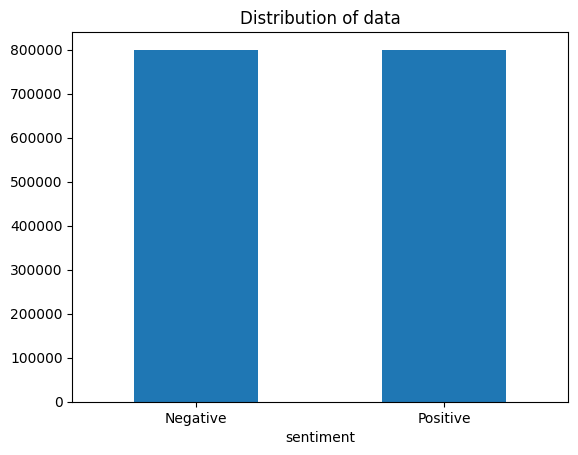

In [2]:
# Импорт данных
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(
    'training.1600000.processed.noemoticon.csv',
    encoding=DATASET_ENCODING , names=DATASET_COLUMNS
    )

# Удаление ненужных столбцов
dataset = dataset[['sentiment','text']]
# Замена значений для облегчения понимания
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

# Построение графика распределения набора данных
ax = dataset.groupby('sentiment').count().plot(
    kind='bar', title='Distribution of data',legend=False
    )
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Хранение данных в списках
texts, sentiments = list(dataset['text']), list(dataset['sentiment'])

<a id='3'></a>
## <strong>3. Предобработка текста</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

**Предварительная обработка текста** традиционно является важным шагом для задач **обработки естественного языка (NLP)**. Он преобразует текст в более удобоваримую форму, чтобы алгоритмы машинного обучения могли работать лучше.

**Выполненные шаги предварительной обработки:**
1. **Нижний регистр:** Каждый текст преобразуется в нижний регистр.
2. **Замена URL-адресов.** Ссылки, начинающиеся с **"http", "https" или "www"**, заменяются на **"URL"**.
3. **Замена смайлов.** Можно заранее подготовить словарь расшифровок смайликов, чтобы произвести в дальнейшем по нему замену. *(например: ":)" на "EMOJIsmile")*
4. **Замена имен пользователей:** Замена @Usernames словом **"USER"**. *(например: "@Kaggle" на "USER")*
5. **Удаление неалфавитных символов:** Замена символов, кроме цифр и букв, на пробел.
6. **Удаление последовательных букв:** 3 или более последовательных букв заменяются двумя. *(например: "Heyyyy" на "Heyy")*
7. **Удаление коротких слов.** Слова длиной менее 2 удаляются.
8. **Удаление стоп-слов.** Стоп-слова — это английские слова, которые не придают предложению особого значения. Их можно смело игнорировать, не жертвуя смыслом предложения. *(например: "the", "he", "have")*
9. **Лемматизация.** Лемматизация – это процесс преобразования слова в его базовую форму. *(например: "Great" на "Good")*

In [3]:
# Cловарь, содержащий смайлы с их значениями
emojis = {
    ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
    ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
    ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
    ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
    '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
    '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
    ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'
    }

# Список стопслов
nltk_stopwords = stopwords.words('english')

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Создаем лемматизатор
    wordLemm = WordNetLemmatizer()
    
    # Определение шаблонов регулярных выражений
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Замена адресов на 'URL'
        tweet = re.sub(urlPattern,' URL', tweet)
        # Замено эмодзи
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Замена @USERNAME на 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Замена нечисловых и небуквенных символов
        tweet = re.sub(alphaPattern, " ", tweet)
        # Замена 3 или более букв подряд на 2 буквы
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Проверяем, является ли слово стоп-словом
            # если слова нет в списке стоп-слов:
            if len(word)>1:
                # Лемматизация слова
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [9]:
import time
t = time.time()
processedtexts = preprocess(texts)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 62 seconds


Сравним исходный вариант с преобрахованным

In [31]:
for _ in range(5):
    random_idx = np.random.randint(len(texts))
    print(texts[random_idx])
    print(processedtexts[random_idx], '\n')

time to get ready for one of that last places on earth that i want to go  not fun anyone willing to switch places with me?
time to get ready for one of that last place on earth that want to go not fun anyone willing to switch place with me  

@kombiz dang -- good work. Save a couple for when I get back from C'ville, pls 
USER dang good work save couple for when get back from ville pls  

Hates cleaning her room. 
hate cleaning her room  

@NKOTBlockhead @NorCAlly HAVE A BLAST AND PLEASE BE SAFE!! &lt;3 i wish i could be there w/ you guys!! 
USER USER have blast and please be safe lt wish could be there you guy  

@JayFingers @lmpotter Thanks for the #followfriday guys 
USER USER thanks for the followfriday guy  



<a id='4'></a>
## <strong>4. Анализ данных</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

Теперь мы проанализируем предварительно обработанные данные, чтобы понять их. Мы построим график **Word Clouds** для **положительных и отрицательных** твитов из нашего набора данных и посмотрим, какие слова встречаются чаще всего.

### Word-Cloud для негативных твитов.

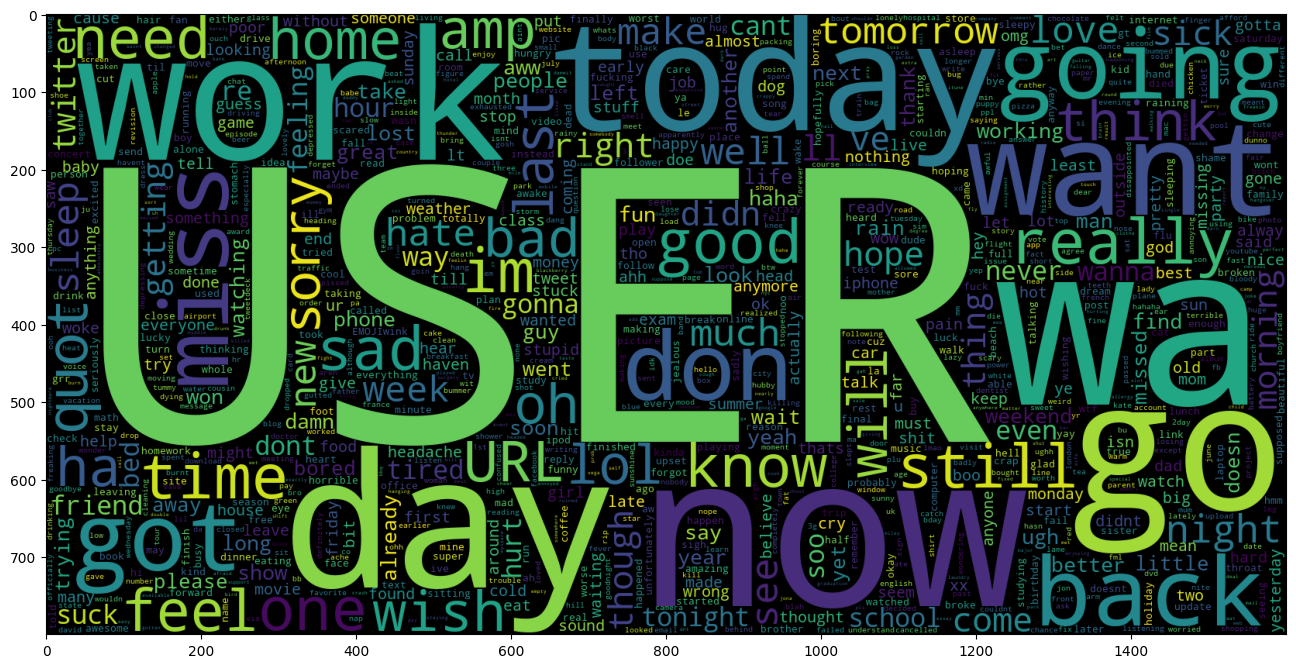

In [34]:
data_neg = processedtexts[:800000]
plt.figure(figsize = (16, 10))
wc = WordCloud(
    max_words=1000, width=1600,
    height=800, collocations=False
    ).generate(" ".join(data_neg))
plt.imshow(wc);

### Word-Cloud для позитивных твитов.

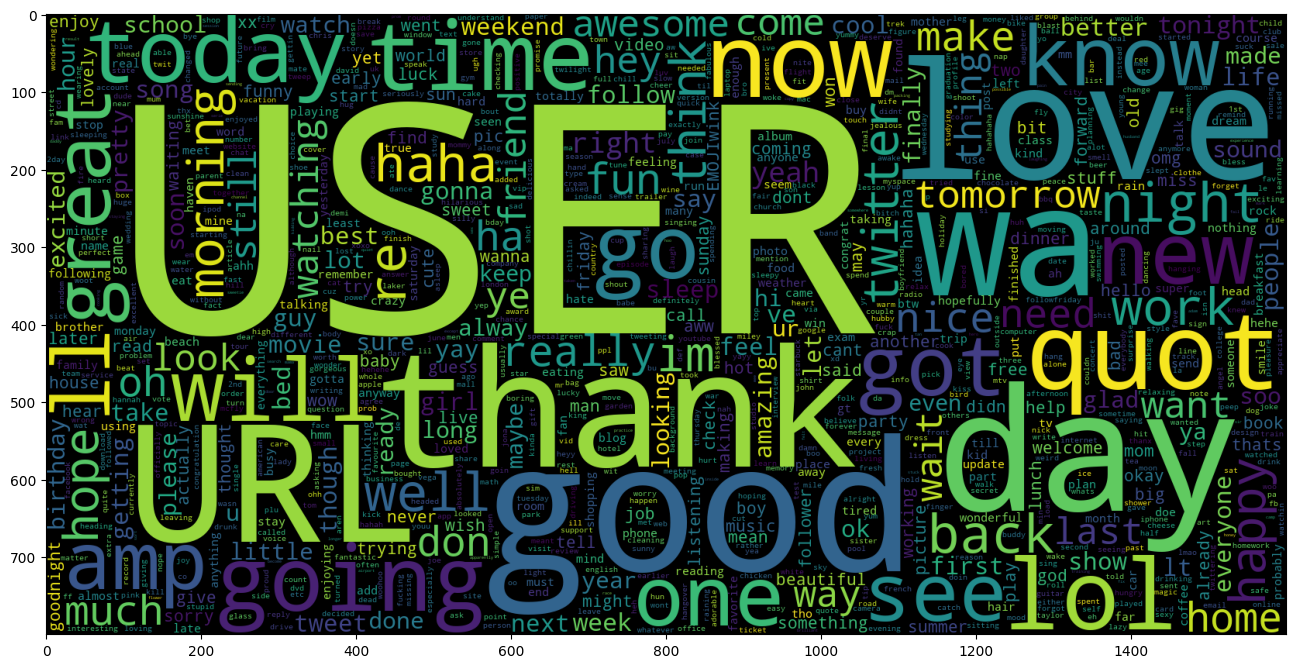

In [35]:
data_pos = processedtexts[800000:]
wc = WordCloud(
    max_words=1000, width=1600,
    height=800, collocations=False
    ).generate(" ".join(data_pos))
plt.figure(figsize = (16,10))
plt.imshow(wc);

<a id='5'></a>
## <strong>5. Сэмплирование</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

Предварительно обработанные данные будут разделены на 2 выборки:
* **Треннировочная:** Выборка, на которой будет обучаться модель. Содержит 90% данных.
* **Валидационная:** Выборка, на которой будет тестироваться модель. Содержит 10% данных.

In [39]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    processedtexts, sentiments,
    test_size=0.1, random_state=42
    )
print(f'Data Split done.')

Data Split done.
CPU times: total: 484 ms
Wall time: 481 ms


<a id='6'></a>
## <strong>6. Векторизация</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

TF-IDF указывает, насколько важно слово для понимания документа или набора данных.

**TF-IDF Vectoriser** преобразует коллекцию необработанных документов в **матрицу функций TF-IDF**. **Vectoriser** обычно обучается только на наборе данных **X_train**.

**ngram_range** — это диапазон количества слов в последовательности: например, «очень дорогой» — это 2-грамм, которые считаются дополнительной функцией отдельно от «очень» и «дорого», когда у вас есть диапазон n-грамм (1, 2).

**max_features** указывает количество функций, которые следует учитывать (упорядочено по частоте признаков в корпусе).

In [41]:
%%time
vectoriser = TfidfVectorizer(
    ngram_range=(1, 2), max_features=500000
    )
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words:', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words: 500000
CPU times: total: 29.6 s
Wall time: 29.6 s


Преобразование набора данных **X_train** и **X_test** в матрицу **TF-IDF** с помощью **TfidfVectorizer**. Эти наборы данных будут использоваться для обучения модели и ее тестирования.

In [42]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


<a id='7'></a>
## <strong>7. Создание и оценка моделей</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

Создадим четыре различных типа моделей для нашей задачи анализа настроений:
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**
* **CatBoost Classifier (CBC)**

Поскольку наш набор данных не сбалансирован, т. е. он имеет равное количество положительных и отрицательных прогнозов. В качестве показателя оценки мы выбираем **Accuracy**. Кроме того, мы строим **Confusion Matrix**.

### Функция для оценки модели

In [74]:
def model_Evaluate(model):
    
    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test)

    # Вывод отчета по метрикам предсказаний
    print(classification_report(y_test, y_pred, digits=4))
    
    # Вычислиние и вывод Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative', 'Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    group_percentages = np.asarray(group_percentages).reshape(2, 2)
    
    display(pd.DataFrame(data=group_percentages, columns=categories, index=categories))

<a id='7.1'></a>
### <strong>7.1 BernoulliNB Model</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

In [75]:
%%time
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0     0.8082    0.7925    0.8003     79812
           1     0.7974    0.8129    0.8051     80188

    accuracy                         0.8027    160000
   macro avg     0.8028    0.8027    0.8027    160000
weighted avg     0.8028    0.8027    0.8027    160000



,Negative,Positive
Negative,39.53%,10.35%
Positive,9.38%,40.74%


CPU times: total: 734 ms
Wall time: 741 ms


<a id='7.2'></a>
### <strong>7.2 LinearSVC Model</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

In [76]:
%%time
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0     0.8195    0.8071    0.8133     79812
           1     0.8108    0.8231    0.8169     80188

    accuracy                         0.8151    160000
   macro avg     0.8152    0.8151    0.8151    160000
weighted avg     0.8152    0.8151    0.8151    160000



,Negative,Positive
Negative,40.26%,9.62%
Positive,8.87%,41.25%


CPU times: total: 1min 41s
Wall time: 1min 40s


<a id='7.3'></a>
### <strong>7.3 Logistic Regression Model</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

In [77]:
%%time
LRmodel = LogisticRegression(
    C=2, max_iter=1000, n_jobs=-1
    )
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0     0.8310    0.8168    0.8238     79812
           1     0.8207    0.8346    0.8276     80188

    accuracy                         0.8257    160000
   macro avg     0.8258    0.8257    0.8257    160000
weighted avg     0.8258    0.8257    0.8257    160000



,Negative,Positive
Negative,40.74%,9.14%
Positive,8.29%,41.83%


CPU times: total: 609 ms
Wall time: 32.6 s


<a id='7.4'></a>
### <strong>7.4 CatBoost Classifier</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

In [78]:
%%time
CBCmodel = CatBoostClassifier(
    verbose=False, random_seed=42
    )
CBCmodel.fit(X_train, y_train)
model_Evaluate(CBCmodel)

              precision    recall  f1-score   support

           0     0.8169    0.7848    0.8005     79812
           1     0.7939    0.8249    0.8091     80188

    accuracy                         0.8049    160000
   macro avg     0.8054    0.8048    0.8048    160000
weighted avg     0.8053    0.8049    0.8048    160000



,Negative,Positive
Negative,39.15%,10.73%
Positive,8.78%,41.34%


CPU times: total: 4h 12min 6s
Wall time: 28min 39s


Мы ясно видим, что логистическая регрессия работает лучше всего из всех опробованных нами моделей. Она достигает точности выше 82% на тестовой выборке.

Хотя следует также отметить, что BernoulliNB является самой быстрой для обучения и прогнозирования. Она также обеспечивает точность 80%.

А вот модели на алгоритмах с градиентным бустингом, пожалуй, лучше не использовать — по крайней мере, не в первую очередь.

<a id='8'></a>
## <strong>8. Сохранение моделей</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

Воспользуемся pickle, чтобы сохранить векторизатор, BernoulliNB и модель логистической регрессии для дальнейшего использования.

In [82]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

<a id='9'></a>
## <strong>9. Инференс моделей</strong>
</strong></p>

<a href ="#0">Вернуться к оглавлению.</a>

Чтобы использовать модель для sentiment анализа, нам необходимо импортировать векторизатор и модель — также с помощью рickle.

Векторизатор можно использовать для преобразования данных в матрицу TF-IDF фич.

Хотя модель можно использовать для прогнозирования настроения преобразованных данных, текст, настроение которого необходимо предсказать, должен быть предварительно обработан.

In [83]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Загрузка векторизатора
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Загрузка модели
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Векторизация и предсказание
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Составим список текста с настроением
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Преобразуем список в DataFrame
    df = pd.DataFrame(data, columns = ['text', 'sentiment'])
    df = df.replace([0, 1], ["Negative", "Positive"])
    return df

if __name__=="__main__":
    # Загрузка при необходимости
    #vectoriser, LRmodel = load_models()
    
    # Набор текстов для классификации нужно собрать в список 
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative
